Optimization cost for restored_image_750.png: 508.44


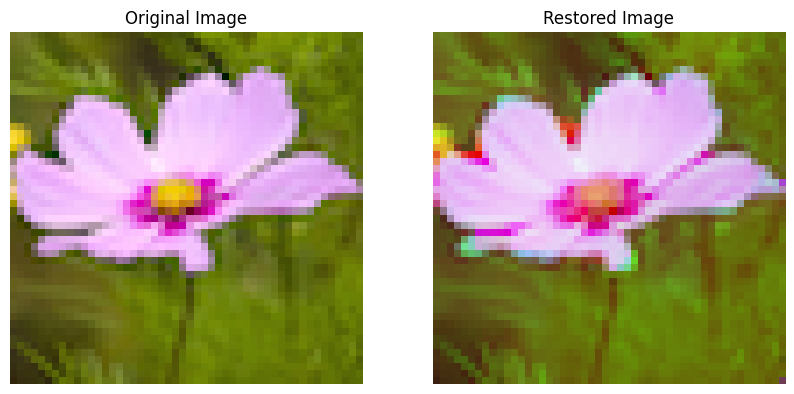

Optimization cost for restored_image_1000.png: 523.53


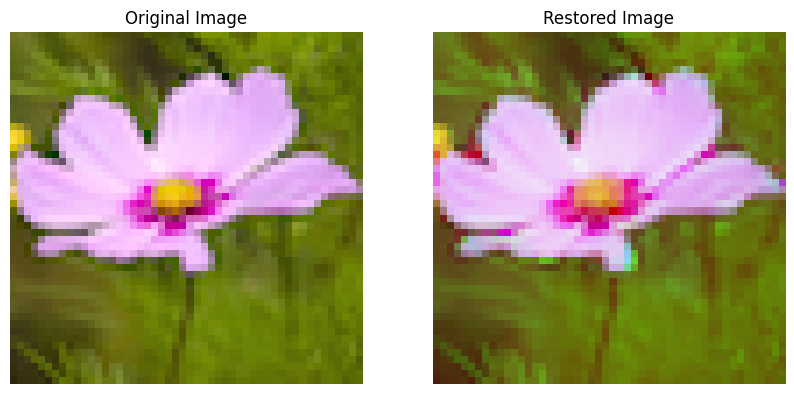

Optimization cost for restored_image_1500.png: 543.57


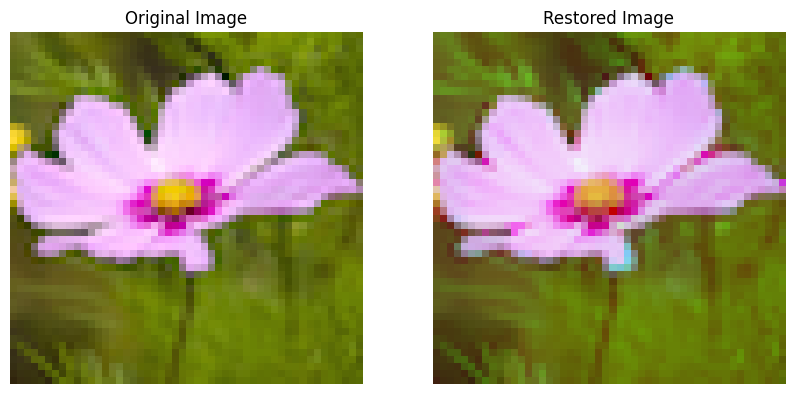

Optimization cost for restored_image_2000.png: 559.53


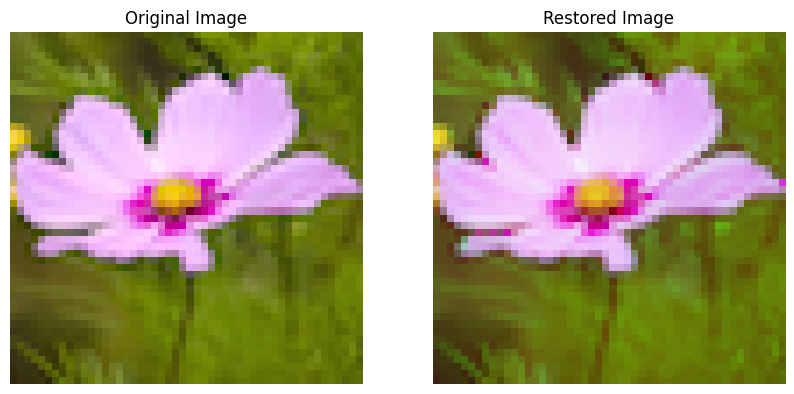

Optimization cost for restored_image_2250.png: 567.09


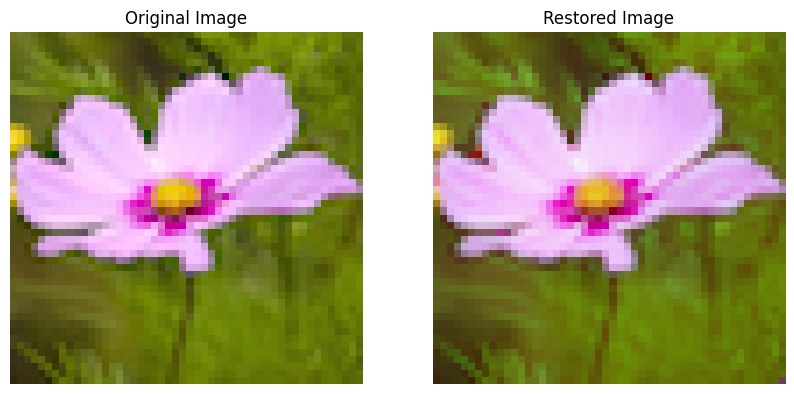

In [2]:
import cvxpy as cp
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_images(original_image_path, grayscale_image_path, known_colors_image_path):
    """Load the original, grayscale, and known colors images."""
    original_image = cv2.imread(original_image_path) / 255.0  # Normalize to [0, 1]
    gray_image = cv2.imread(grayscale_image_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize to [0, 1]
    known_colors_image = cv2.imread(known_colors_image_path) / 255.0  # Normalize to [0, 1]
    return original_image, gray_image, known_colors_image

def solve_optimization(gray_image, known_colors_image, lambda_known=10):
    """Solve the optimization problem to restore the color image."""
    # Image dimensions
    m, n = gray_image.shape

    # Extract the known R, G, B channels from the known color image
    R_known = known_colors_image[:, :, 0]
    G_known = known_colors_image[:, :, 1]
    B_known = known_colors_image[:, :, 2]

    # Create variables for R, G, B channels to be optimized
    R = cp.Variable((m, n))
    G = cp.Variable((m, n))
    B = cp.Variable((m, n))

    # Define the grayscale constraint (use a tolerance to avoid strict equality)
    epsilon = 1e-3
    grayscale_constraint = [cp.abs(gray_image - (0.299 * R + 0.587 * G + 0.114 * B)) <= epsilon]

    # Relax the known color constraints using penalties
    color_loss = lambda_known * (
        cp.sum_squares(cp.multiply(known_colors_image[:, :, 0] > 0, R - R_known)) +
        cp.sum_squares(cp.multiply(known_colors_image[:, :, 1] > 0, G - G_known)) +
        cp.sum_squares(cp.multiply(known_colors_image[:, :, 2] > 0, B - B_known))
    )

    # Ensure pixel values are within [0, 1]
    value_constraints = [R >= 0, R <= 1, G >= 0, G <= 1, B >= 0, B <= 1]

    # Define the total variation minimization objective
    objective = cp.Minimize(
        cp.tv(R) + cp.tv(G) + cp.tv(B) + color_loss
    )

    # Combine all constraints
    constraints = grayscale_constraint + value_constraints

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status not in ["infeasible", "unbounded"]:
        # Get the resulting color channels
        R_result = R.value
        G_result = G.value
        B_result = B.value

        # Stack the channels back into a color image
        restored_image = np.stack([R_result, G_result, B_result], axis=-1)
        return restored_image, prob.value
    else:
        print(f"Problem status: {prob.status}")
        return None, None

def save_and_plot_images(original_image, restored_image, output_filename):
    """Save and plot the original and restored images side by side."""
    if restored_image is not None:
        # Scale the image to [0, 255] and convert to uint8
        restored_image_uint8 = (restored_image * 255.0).astype(np.uint8)
        cv2.imwrite(output_filename, restored_image * 255.0)

        # Convert images to RGB format for plotting (OpenCV uses BGR by default)
        original_image_uint8 = (original_image * 255.0).astype(np.uint8)
        original_image_rgb = cv2.cvtColor(original_image_uint8, cv2.COLOR_BGR2RGB)
        restored_image_rgb = cv2.cvtColor(restored_image_uint8, cv2.COLOR_BGR2RGB)

        # Plot the original and restored images side by side
        plt.figure(figsize=(10, 5))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image_rgb)
        plt.title('Original Image')
        plt.axis('off')

        # Restored image
        plt.subplot(1, 2, 2)
        plt.imshow(restored_image_rgb)
        plt.title('Restored Image')
        plt.axis('off')

        plt.show()

def run_optimization_for_multiple_images(original_image_path, grayscale_image_path, known_colors_image_paths, output_filenames, lambda_known=10):
    """Run the optimization for multiple known colors images."""
    original_image, gray_image, _ = load_images(original_image_path, grayscale_image_path, known_colors_image_paths[0])

    for known_colors_image_path, output_filename in zip(known_colors_image_paths, output_filenames):
        _, _, known_colors_image = load_images(original_image_path, grayscale_image_path, known_colors_image_path)
        restored_image, cost = solve_optimization(gray_image, known_colors_image, lambda_known)
        
        if restored_image is not None:
            print(f"Optimization cost for {output_filename}: {cost:.2f}")
            save_and_plot_images(original_image, restored_image, output_filename)
        else:
            print(f"Failed to optimize for {known_colors_image_path}")

if __name__ == "__main__":
    original_image_path = 'flower.png'
    grayscale_image_path = 'grayscale_image.png'
    known_colors_image_paths = [
        'known_colors_image_750.png',
        'known_colors_image_1000.png',
        'known_colors_image_1500.png',
        'known_colors_image_2000.png',
        'known_colors_image_2250.png'
    ]
    output_filenames = [
        'restored_image_750.png',
        'restored_image_1000.png',
        'restored_image_1500.png',
        'restored_image_2000.png',
        'restored_image_2250.png'
    ]

    run_optimization_for_multiple_images(original_image_path, grayscale_image_path, known_colors_image_paths, output_filenames)
